# Face Recognition 

## 1. Importing Libraries

In [1]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from Feature_Extraction import *
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.base import clone
from sklearn.svm import SVC
from skimage import color
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np
import imghdr
import glob
import cv2
import os

C:\Users\kimh1\AppData\Local\Temp\ipykernel_9888\1777935070.py:17: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## 2. Load Folder

In [2]:
def load_images(data_path):
    images = []
    labels = []

    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            for image_filename in os.listdir(person_dir):
                if image_filename.endswith('.jpg'):
                    image_path = os.path.join(person_dir, image_filename)
                    image = cv2.imread(image_path)

                    images.append(image)

                    labels.append(person_name)

    images = np.array(images)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    return {
        'data': images,
        'target': labels,
        'target_names': unique_labels
    }


In [3]:
dataset = load_images('./Data/')

In [4]:
# BACKUP
lfw_dataset = dataset.copy()
print("Shape of images:", dataset['data'].shape)
print("Shape of labels:", dataset['target'].shape)
print("Unique labels:", dataset['target_names'].shape)

Shape of images: (13233, 250, 250, 3)
Shape of labels: (13233,)
Unique labels: (5749,)


## 3. Data Visualization

### Scatter Plot

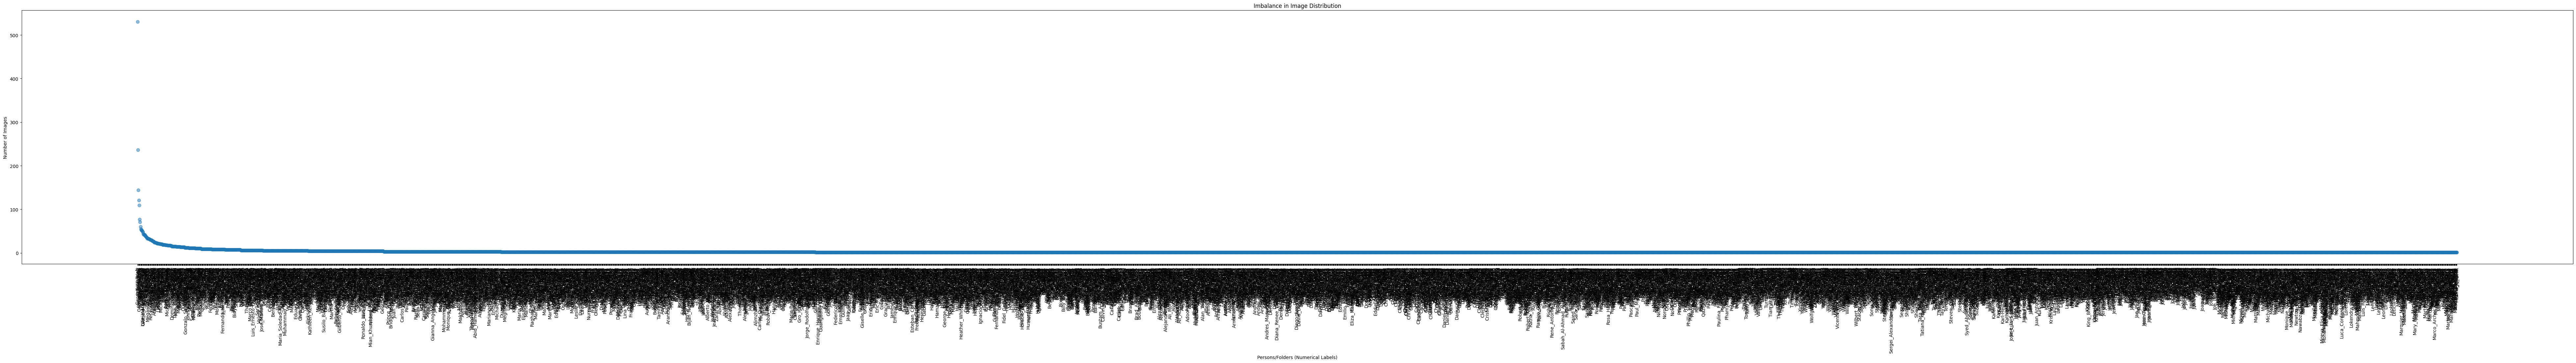

In [5]:
# Assuming dataset is a dictionary with 'data', 'target', and 'target_names' keys
unique_labels, label_counts = np.unique(dataset['target'], return_counts=True)

# Sort labels and counts by count in descending order
sorted_counts_indices = np.argsort(label_counts)[::-1]
sorted_labels = unique_labels[sorted_counts_indices]
sorted_counts = label_counts[sorted_counts_indices]

# Plotting the bar plot
plt.figure(figsize=(100, 10))
plt.scatter(sorted_labels, sorted_counts, marker='o',s=50, alpha= 0.5)
plt.xlabel('Persons/Folders (Numerical Labels)')
plt.ylabel('Number of Images')
plt.title('Imbalance in Image Distribution')
plt.xticks(rotation=90) 
plt.show()

### Image Distribuition of Top 20 People

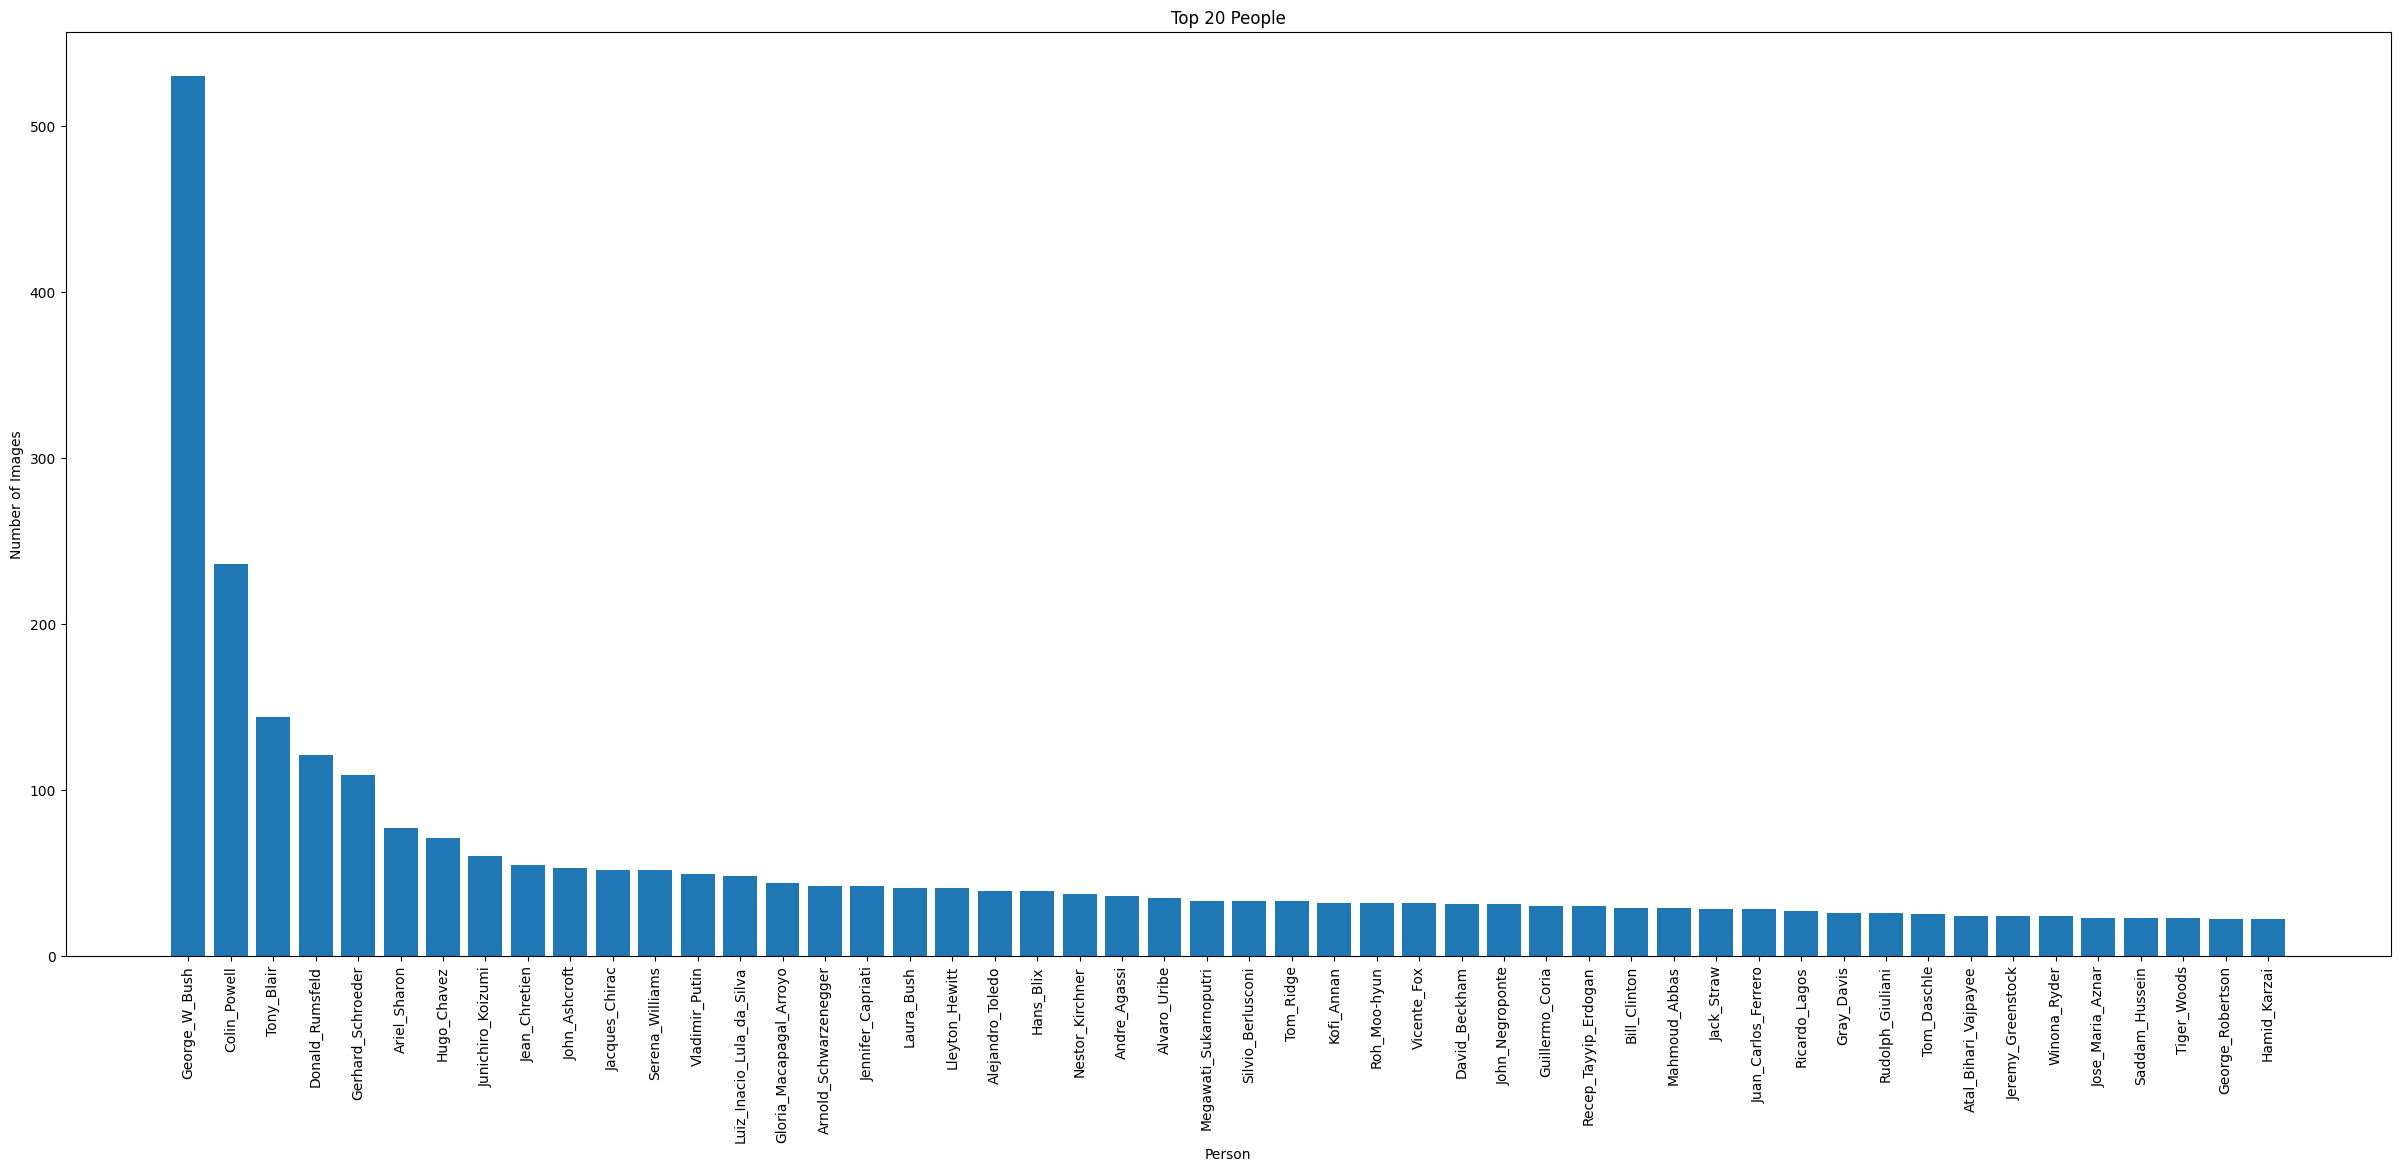

In [6]:
target_counts = Counter(dataset['target'])

top_20_people = target_counts.most_common(50)

plt.figure(figsize=(30, 12))
plt.bar(*zip(*top_20_people))
plt.xlabel('Person')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Top 20 People')
plt.show()

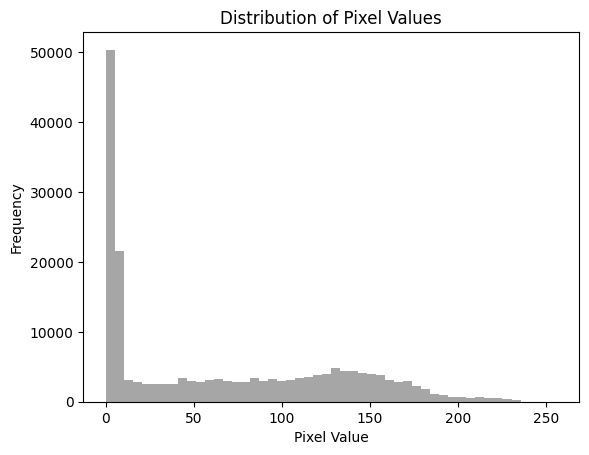

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming dataset is a dictionary with 'data' key containing the image data
image_data = dataset['data'][0]

# Flatten the image data
pixels = pd.Series(image_data.flatten())

# Plotting the histogram
plt.hist(pixels, bins=50, range=[0, 256], density=False, color='gray', alpha=0.7)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


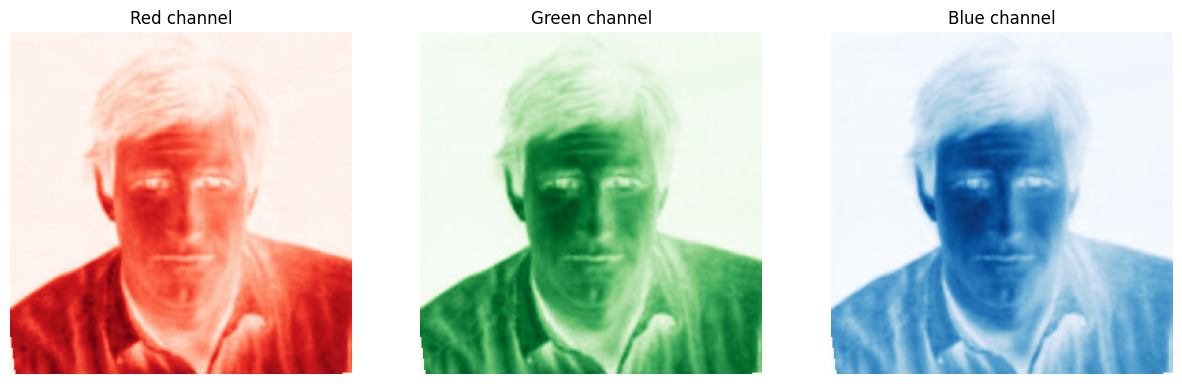

In [8]:
# Display RGB Channels of our image
image = dataset['data'][0]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(image[:, :, 0], cmap='Reds')
axs[1].imshow(image[:, :, 1], cmap='Greens')
axs[2].imshow(image[:, :, 2], cmap='Blues')

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

axs[0].set_title('Red channel')
axs[1].set_title('Green channel')
axs[2].set_title('Blue channel')

plt.show()

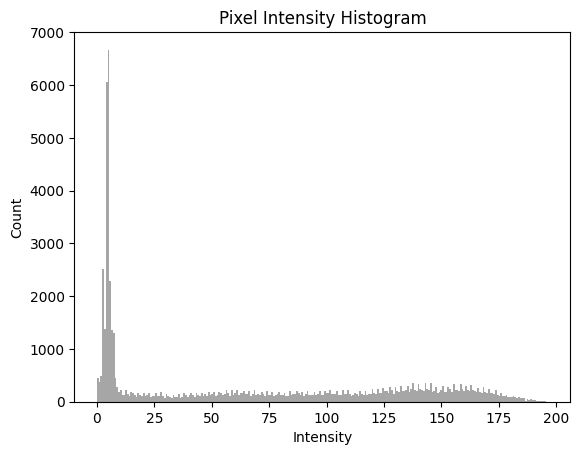

In [9]:
# Convert the image to grayscale if it's in color
if len(image.shape) > 2:
    image = np.mean(image, axis=2)

# Flatten the image to a 1D array
pixels = image.flatten()

# Plot the histogram
plt.hist(pixels, bins=256, color='gray', alpha=0.7)
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title('Pixel Intensity Histogram')

# Show the plot
plt.show()

### Distribuition of Pixel Values

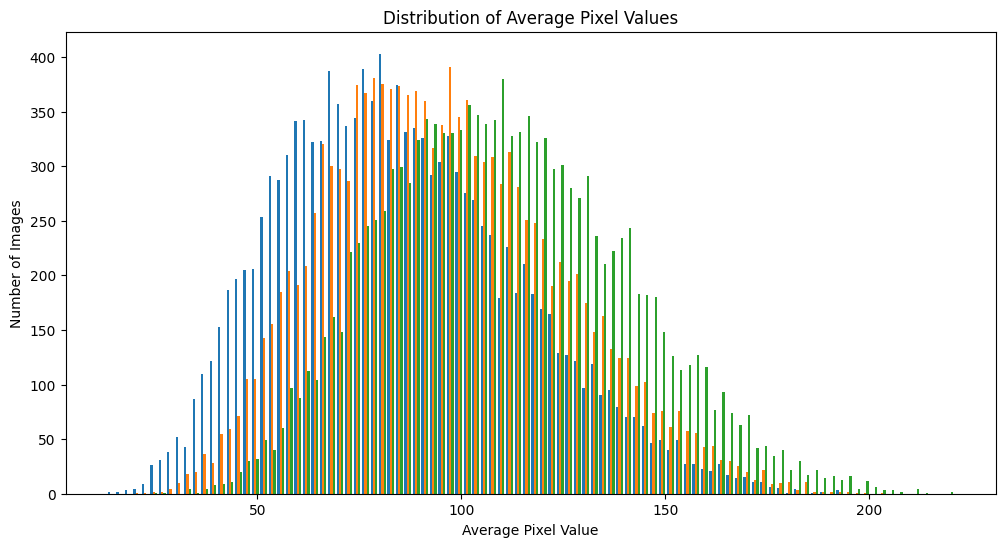

In [10]:
avg_pixel_values = np.mean(dataset['data'], axis=(1, 2))

# Plot the distribution of average pixel values
plt.figure(figsize=(12, 6))

plt.hist(avg_pixel_values, bins=100)

plt.xlabel('Average Pixel Value')

plt.ylabel('Number of Images')

plt.title('Distribution of Average Pixel Values')

plt.show()

### Histogram

In [11]:
target_counts = Counter(dataset['target'])
ranges = [(1, 1), (2, 5), (6, 10), (11, 20), (21, 30), (31, 80), (81, np.inf)]
labels = ['1', '2-5', '6-10', '11-20', '21-30', '31-80', '>81']

people_counts = [0] * len(ranges)
image_counts = [0] * len(ranges)

# For each person, increment the count for the appropriate range
for person, count in target_counts.items():
    for i, (min_count, max_count) in enumerate(ranges):
        if min_count <= count <= max_count:
            people_counts[i] += 1
            image_counts[i] += count
            break

# Calculate the percentages
total_people = sum(people_counts)
total_images = sum(image_counts)
people_percentages = [f"{count / total_people * 100:.2f}" for count in people_counts]
images_percentages = [f"{count / total_images * 100:.2f}" for count in image_counts]

# Create a DataFrame
df = pd.DataFrame({
    'Number of images/person': labels,
    'Number of people': people_counts,
    'Percentage of people': people_percentages,
    'Number of images': image_counts,
    'Percentage of images': images_percentages
})

df

Number of images/person  Number of people Percentage of people  \
0                       1              4069                70.78   
1                     2-5              1369                23.81   
2                    6-10               168                 2.92   
3                   11-20                86                 1.50   
4                   21-30                25                 0.43   
5                   31-80                27                 0.47   
6                     >81                 5                 0.09   

   Number of images Percentage of images  
0              4069                30.75  
1              3739                28.26  
2              1251                 9.45  
3              1251                 9.45  
4               613                 4.63  
5              1170                 8.84  
6              1140                 8.61

### Plot Some Images

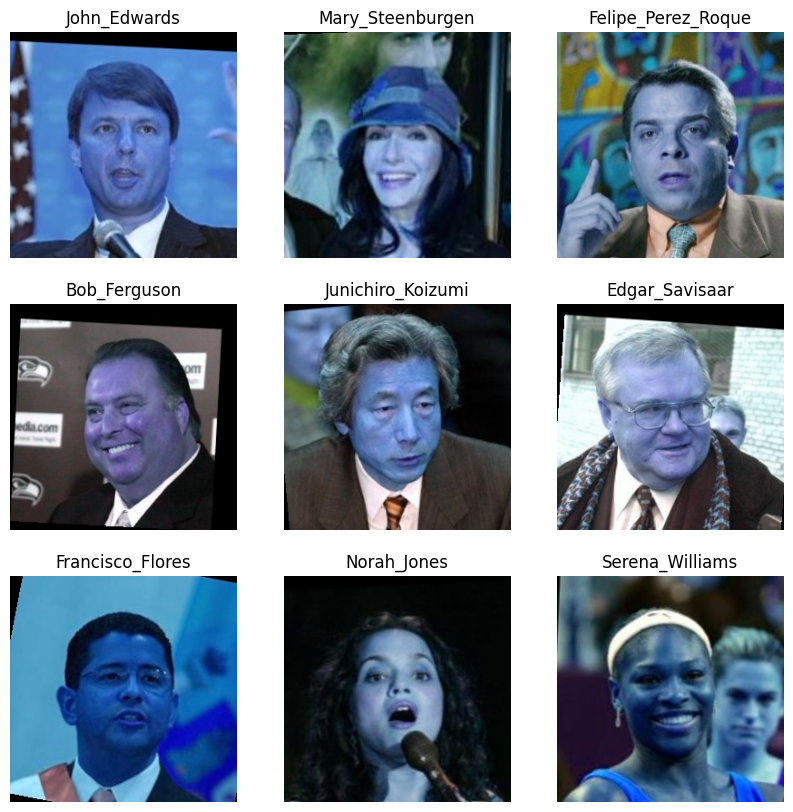

In [12]:
# Function to display a random set of images
def display_random_images(images, labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(labels[index])

    plt.show()

display_random_images(dataset['data'], dataset['target'], 3, 3)

## 4. Data Preprocessing

In [13]:
dataset = lfw_dataset.copy()

### Image Resizing

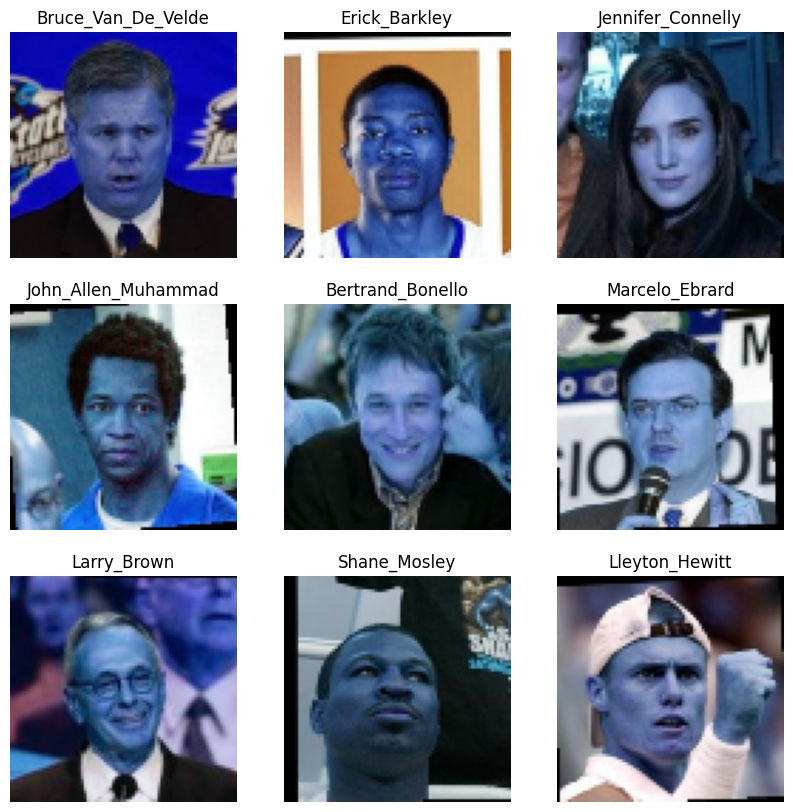

In [14]:
def resize_image(images, target_size=(100, 100)):
    resized_images = [cv2.resize(image, target_size) for image in images]
    return np.array(resized_images)

resized_images = resize_image(dataset['data'], target_size=(80, 80))

display_random_images(resized_images, dataset['target'], 3, 3)

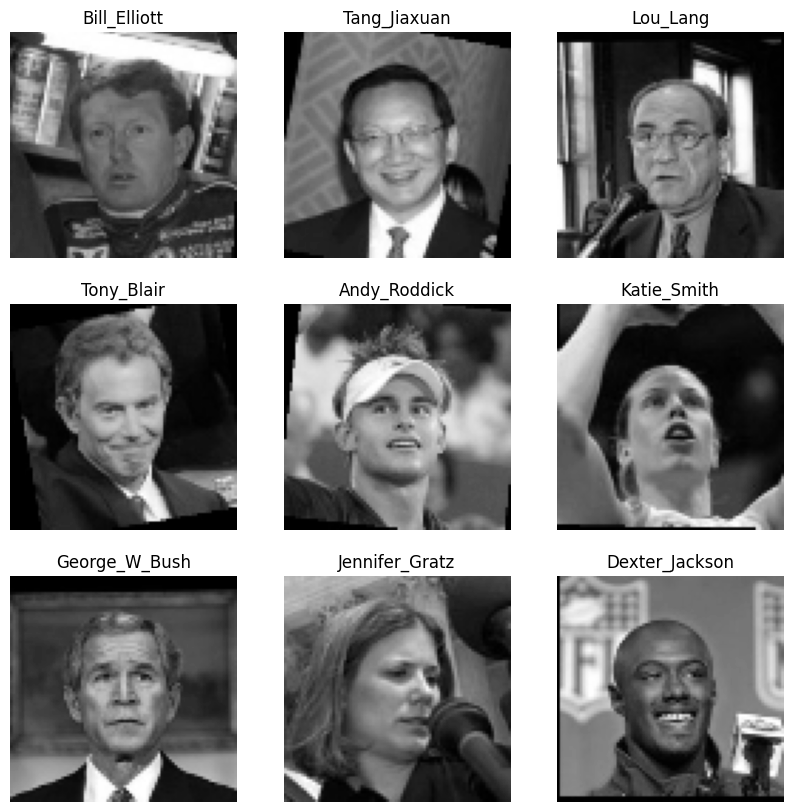

In [44]:
# Gray scale
def gray_scale(images):
    gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
    return np.array(gray_images)

gray_images = gray_scale(resized_images)

display_random_images(gray_images, dataset['target'], 3, 3, cmap='gray')

In [16]:
def detect_faces(images, target_size=(64, 64)):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    face_images = []
    for image in images:
        faces = face_cascade.detectMultiScale(image, minNeighbors=10, minSize=(80, 80))
        for (x, y, w, h) in faces:
            face_roi = cv2.resize(image[y:y + h, x:x + w], target_size)
            face_images.append(face_roi)

    return np.array(face_images)

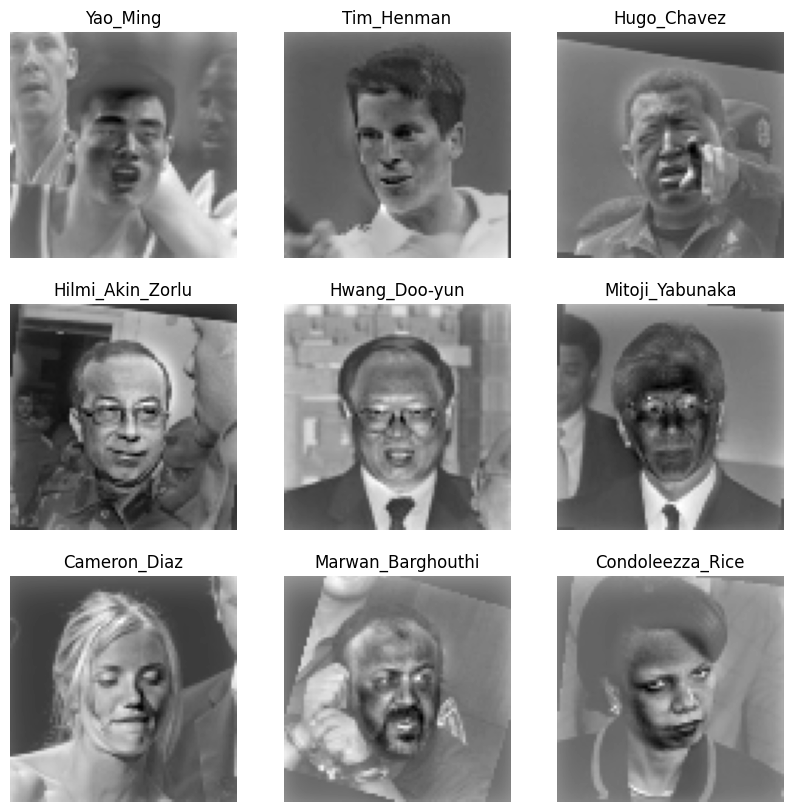

In [17]:
images = gray_images.copy()

scaler = StandardScaler()
# Get the original shape
original_shape = images.shape[1:]

# Reshape and scale the images
scaled_images = scaler.fit_transform(images.reshape(-1, np.prod(original_shape))).reshape(-1, *original_shape)

display_random_images(scaled_images, dataset['target'], 3, 3, cmap='gray')

## 5. Feature Extractions

### 5.1. Filter Dataset

In [18]:
def filter_dataset(dataset, min_faces_per_person):
    # Count the number of images for each person
    target_counts = Counter(dataset['target'])

    # Initialize the filtered dataset
    filtered_dataset = {
        'data': [],
        'target': [],
        'target_names': set()
    }

    # For each image and its corresponding label
    for image, label in zip(dataset['data'], dataset['target']):
        # If this person has at least min_faces_per_person images
        if target_counts[label] >= min_faces_per_person:
            # Add this image and label to the filtered dataset
            filtered_dataset['data'].append(image)
            filtered_dataset['target'].append(label)
            filtered_dataset['target_names'].add(label)

    filtered_dataset['data'] = np.array(filtered_dataset['data'])
    filtered_dataset['target'] = np.array(filtered_dataset['target'])
    filtered_dataset['target_names'] = np.array(list(filtered_dataset['target_names']))

    return filtered_dataset

dataset['data'] = scaled_images.copy()

filtered_dataset = filter_dataset(dataset, min_faces_per_person=20)

In [19]:
filtered_dataset['data'].shape
filtered_dataset['target'].shape

n_samples, h, w = filtered_dataset['data'].shape
n_features = filtered_dataset['data'].shape[1] 
print("Number of Data Samples: % d" % n_samples) 
print("Size of a data sample: % d" % n_features) 
print("Shape of images:", filtered_dataset['data'].shape)

Number of Data Samples:  3023
Size of a data sample:  80
Shape of images: (3023, 80, 80)


### 5.2. Image Agumentation 

### 5.3. Spliting Train and Test Set

In [20]:
X = filtered_dataset['data']
y = filtered_dataset['target']

X = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2418, 6400)
Shape of X_test: (605, 6400)
Shape of y_train: (2418,)
Shape of y_test: (605,)


### 5.4. Principal Component Analysis (PCA):

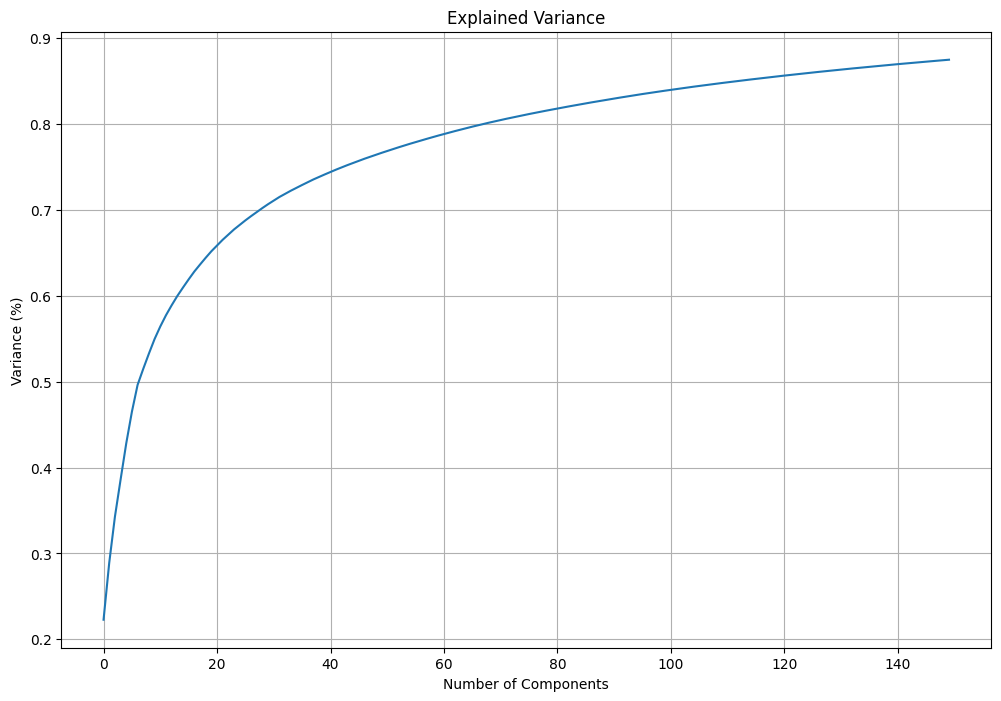

In [21]:
X_train_pca, X_test_pca, pca = pca_transform(X_train, X_test, n_components=150)
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.grid(True)
plt.show()

In [22]:
svm_clf = SVC(kernel="rbf", class_weight="balanced", C=1000, gamma=0.001, random_state=42)
# Train the model on the training set
svm_clf.fit(X_train_pca, y_train)

y_pred_pca = svm_clf.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy:", accuracy_pca )
print("\nClassification Report:\n", classification_report(y_test, y_pred_pca))

Accuracy: 0.5504132231404959

Classification Report:
                            precision    recall  f1-score   support

         Alejandro_Toledo       0.57      0.50      0.53         8
             Alvaro_Uribe       0.71      0.71      0.71         7
          Amelie_Mauresmo       0.50      0.25      0.33         4
             Andre_Agassi       0.00      0.00      0.00         7
           Angelina_Jolie       0.00      0.00      0.00         4
             Ariel_Sharon       0.40      0.38      0.39        16
    Arnold_Schwarzenegger       0.17      0.38      0.23         8
     Atal_Bihari_Vajpayee       0.33      0.40      0.36         5
             Bill_Clinton       0.38      0.50      0.43         6
             Carlos_Menem       0.33      0.25      0.29         4
             Colin_Powell       0.65      0.77      0.71        47
            David_Beckham       0.33      0.17      0.22         6
          Donald_Rumsfeld       0.64      0.58      0.61        24
       

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

##### Ploting image with eigenfaces

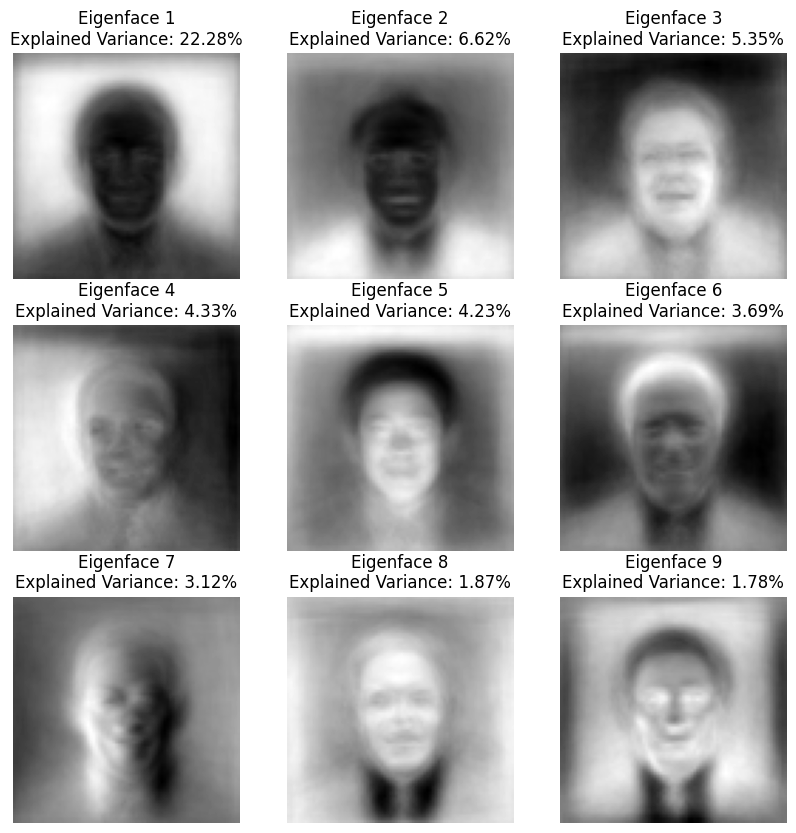

In [23]:
# Assuming pca is your PCA object and X_train is your training data
# Calculate explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the eigenfaces with information in the title
def plot_eigenfaces(components, h, w, rows, cols, explained_variance_ratio):
    plt.figure(figsize=(10, 10))

    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(components[i].reshape((h, w)), cmap='gray')
        plt.title(f'Eigenface {i + 1}\nExplained Variance: {explained_variance_ratio[i]*100:.2f}%')
        plt.axis('off')

    plt.show()

# Assuming your images have dimensions 80x80, adjust as needed
plot_eigenfaces(pca.components_, original_shape[0], original_shape[1], 3, 3, explained_variance_ratio)

### 5.5. Local Binary Patterns (LBP):

In [24]:
from skimage import feature
import numpy as np

X_train_lbp = lbp_transform(X_train.reshape(-1, *original_shape))
X_test_lbp = lbp_transform(X_test.reshape(-1, *original_shape))

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [25]:
# Use SVM classifier on LBP features
clf_lbp = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
clf_lbp.fit(X_train_lbp, y_train)

# Predict on the LBP test set
y_pred_lbp = clf_lbp.predict(X_test_lbp)
accuracy_lbp = accuracy_score(y_test, y_pred_lbp)
# Print the accuracy and classification report for LBP
print("\nAccuracy (LBP):",accuracy_lbp )
print("\nClassification Report (LBP):\n", classification_report(y_test, y_pred_lbp))


Accuracy (LBP): 0.17520661157024794

Classification Report (LBP):
                            precision    recall  f1-score   support

         Alejandro_Toledo       0.00      0.00      0.00         8
             Alvaro_Uribe       0.00      0.00      0.00         7
          Amelie_Mauresmo       0.00      0.00      0.00         4
             Andre_Agassi       0.00      0.00      0.00         7
           Angelina_Jolie       0.00      0.00      0.00         4
             Ariel_Sharon       0.00      0.00      0.00        16
    Arnold_Schwarzenegger       0.00      0.00      0.00         8
     Atal_Bihari_Vajpayee       0.00      0.00      0.00         5
             Bill_Clinton       0.00      0.00      0.00         6
             Carlos_Menem       0.00      0.00      0.00         4
             Colin_Powell       0.00      0.00      0.00        47
            David_Beckham       0.00      0.00      0.00         6
          Donald_Rumsfeld       0.00      0.00      0.00    

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### 5.6. Linear Discriminant Analysis (LDA):

In [26]:
X_train_lda, X_test_lda = lda_transform(X_train, y_train, X_test)

In [27]:
# Use SVM classifier
clf_lda = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)

clf_lda.fit(X_train_lda, y_train)

y_pred_lda = clf_lda.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test, y_pred_lda)
# Print the accuracy
print("Accuracy:", accuracy_lda)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lda))

Accuracy: 0.45289256198347105

Classification Report:
                            precision    recall  f1-score   support

         Alejandro_Toledo       0.25      0.25      0.25         8
             Alvaro_Uribe       0.50      0.14      0.22         7
          Amelie_Mauresmo       1.00      0.25      0.40         4
             Andre_Agassi       0.00      0.00      0.00         7
           Angelina_Jolie       0.00      0.00      0.00         4
             Ariel_Sharon       0.61      0.69      0.65        16
    Arnold_Schwarzenegger       0.43      0.38      0.40         8
     Atal_Bihari_Vajpayee       0.14      0.20      0.17         5
             Bill_Clinton       0.00      0.00      0.00         6
             Carlos_Menem       0.67      0.50      0.57         4
             Colin_Powell       0.52      0.68      0.59        47
            David_Beckham       0.40      0.33      0.36         6
          Donald_Rumsfeld       0.50      0.17      0.25        24
      

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### 5.7. Discrete Cosine Transform (DCT):

#### 5.7.1. DCT with SVM

In [28]:
# Assuming your images are of size (80, 80)
block_size = 8  # You may adjust the block size based on your requirements

# Split the DCT features into training and testing sets
X_train_dct = extract_dct_features(X_train.reshape(-1, *original_shape), block_size=block_size)
X_test_dct = extract_dct_features(X_test.reshape(-1, *original_shape),block_size=block_size)

# Use SVM classifier on DCT features
clf_dct = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
clf_dct.fit(X_train_dct, y_train)

# Predict on the DCT test set
y_pred_dct = clf_dct.predict(X_test_dct)
accuracy_dct = accuracy_score(y_test, y_pred_dct)
# Print the accuracy and classification report for DCT
print("\nAccuracy (DCT):", accuracy_dct)
print("\nClassification Report (DCT):\n", classification_report(y_test, y_pred_dct))


Accuracy (DCT): 0.17520661157024794

Classification Report (DCT):
                            precision    recall  f1-score   support

         Alejandro_Toledo       0.00      0.00      0.00         8
             Alvaro_Uribe       0.00      0.00      0.00         7
          Amelie_Mauresmo       0.00      0.00      0.00         4
             Andre_Agassi       0.00      0.00      0.00         7
           Angelina_Jolie       0.00      0.00      0.00         4
             Ariel_Sharon       0.00      0.00      0.00        16
    Arnold_Schwarzenegger       0.00      0.00      0.00         8
     Atal_Bihari_Vajpayee       0.00      0.00      0.00         5
             Bill_Clinton       0.00      0.00      0.00         6
             Carlos_Menem       0.00      0.00      0.00         4
             Colin_Powell       0.00      0.00      0.00        47
            David_Beckham       0.00      0.00      0.00         6
          Donald_Rumsfeld       0.00      0.00      0.00    

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

#### 5.7.2. DCT with random forest classification

In [29]:
X_train_dct = extract_dct_features(X_train.reshape(-1, *original_shape), block_size=block_size)
X_test_dct = extract_dct_features(X_test.reshape(-1, *original_shape),block_size=block_size)
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_dct, y_train)

# Make predictions on the test set
y_pred_dctrf = rf_classifier.predict(X_test_dct)

# Calculate accuracy
accuracy_dctrf = accuracy_score(y_test, y_pred_dctrf)
print(f"Accuracy (Random Forest): {accuracy_dctrf}")

Accuracy (Random Forest): 0.2859504132231405


### 5.8. Maximally Stable Extremal Regions (MSER)

In [30]:
X_train.shape

(2418, 6400)

In [31]:
X_test.shape

(605, 6400)

In [32]:
X_mser_tr = X_train.copy()
X_mser_ts = X_test.copy()

In [33]:
X_mser_reshaped_tr = np.reshape(X_mser_tr, (2418, 80, 80))
X_mser_reshaped_ts = np.reshape(X_mser_ts, (605, 80, 80))

In [34]:
X_mser_reshaped_tr.shape

(2418, 80, 80)

In [35]:
# Assuming X_train and X_test are lists of images


X_mser_train = extract_mser_features(X_mser_reshaped_tr)
X_mser_test = extract_mser_features(X_mser_reshaped_ts)

# Reshape the MSER features
X_mser_train_reshaped = X_mser_train.reshape(-1, 1)
X_mser_test_reshaped = X_mser_test.reshape(-1, 1)
# Use SVM classifier on MSER features
clf_mser = SVC(kernel="rbf", class_weight="balanced", C=100, gamma=0.001, random_state=42)
clf_mser.fit(X_mser_train_reshaped, y_train)

# Predict on the MSER test set
y_pred_mser = clf_mser.predict(X_mser_test_reshaped)
accuracy_mser = accuracy_score(y_test, y_pred_mser)

# Print the accuracy and classification report for MSER
print("\nAccuracy (MSER):",accuracy_mser )
print("\nClassification Report (MSER):\n", classification_report(y_test, y_pred_mser))


Accuracy (MSER): 0.008264462809917356

Classification Report (MSER):
                            precision    recall  f1-score   support

         Alejandro_Toledo       0.00      0.00      0.00         8
             Alvaro_Uribe       0.00      0.00      0.00         7
          Amelie_Mauresmo       0.00      0.00      0.00         4
             Andre_Agassi       0.00      0.00      0.00         7
           Angelina_Jolie       0.01      0.25      0.02         4
             Ariel_Sharon       0.00      0.00      0.00        16
    Arnold_Schwarzenegger       0.00      0.00      0.00         8
     Atal_Bihari_Vajpayee       0.00      0.00      0.00         5
             Bill_Clinton       0.00      0.00      0.00         6
             Carlos_Menem       0.00      0.00      0.00         4
             Colin_Powell       0.00      0.00      0.00        47
            David_Beckham       0.00      0.00      0.00         6
          Donald_Rumsfeld       0.00      0.00      0.00 

C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kimh1\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## 7. Accuracy List

## 6. Model Training

In [ ]:
# Accuracy List
models_accuracy = {}

# Define the models
svm_clf = SVC(kernel='rbf', C=1000, gamma=0.001, random_state=42, class_weight='balanced')
lda_clf = LDA()
rf_clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=20, bootstrap=False, random_state=42, class_weight='balanced')
lr_clf = LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', max_iter=400, C=0.01)
knn_clf = KNeighborsClassifier(weights='uniform', n_neighbors=11, metric='euclidean')


# Define feature extraction methods
feature_extraction_methods = {'PCA', 'LDA', 'LBP', 'DCT'}

# Initialize dictionaries to store the models
models = {}

# Loop through models
for model, model_name in zip([svm_clf, lda_clf, rf_clf, lr_clf, knn_clf], ['SVM', 'LDA', 'RF', 'LR', 'KNN']):
    # Loop through feature extraction methods
    for method in feature_extraction_methods:
        # Choose feature extraction method
        if method == 'PCA':
            X_train_transformed = X_train_pca
            X_test_transformed = X_test_pca
        elif method == 'LDA':
            X_train_transformed = X_train_lda
            X_test_transformed = X_test_lda
        elif method == 'LBP':
            X_train_transformed = X_train_lbp
            X_test_transformed = X_test_lbp
        elif method == 'DCT':
            X_train_transformed = X_train_dct
            X_test_transformed = X_test_dct

        # Clone the model to avoid retraining
        cloned_model = clone(model)
        
        # Train the model
        cloned_model.fit(X_train_transformed, y_train)

        # Make predictions on the test set
        y_pred = cloned_model.predict(X_test_transformed)

        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Store the accuracy in the dictionary
        models_accuracy[f'{model_name}_{method}'] = accuracy
        models[f'{model_name}_{method}'] = cloned_model

        # Print results
        print(f'{model_name} with {method} - Accuracy:', accuracy)

# Display the overall accuracy results
print("Overall Accuracy Results:")
print(models_accuracy)

### 6.1. Testing with LDA

In [36]:
# Plot the predict results and its true label

def plot_predict_results(images, true_labels, pred_labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(8, 8))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}')

        # If the prediction is wrong, use red color
        if true_labels[index] != pred_labels[index]:
            plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}', color='red')
        else:
            plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}', color='green')

    plt.show()

# # Make predictions on the test set
y_pred = models['LDA_PCA'].predict(X_test_pca)

plot_predict_results(X_test.reshape(-1, *original_shape), y_test, y_pred, 3, 3, cmap='gray')

ValueError: X has 6400 features, but SVC is expecting 61 features as input.

### 6.2. PCA with SVM

In [37]:
# SVM
from sklearn import svm
from sklearn.model_selection import cross_val_score
# Create an SVM classifier
clf = svm.SVC(kernel="rbf", class_weight="balanced")
# Perform 10-fold cross-validation
scores = cross_val_score(clf,X_train_pca, y_train, cv=10)
# print cross-validation scores with %
print("Cross-validation scores: {}".format(scores * 100))
print("Average cross-validation score: {:.2f}%".format(scores.mean() * 100))
# Train the model
clf.fit(X_train_pca, y_train)


Cross-validation scores: [52.47933884 50.41322314 53.30578512 46.28099174 48.76033058 47.52066116
 50.82644628 51.65289256 53.52697095 51.0373444 ]
Average cross-validation score: 50.58%


SVC(class_weight='balanced')

### 6.2. Save & Load Model

In [38]:
import pickle

# if model.pkl not exists, create it
if not os.path.exists('model.pkl'):
    with open('model.pkl', 'wb') as f:
        pickle.dump(clf, f)

Predicted label: Jiang_Zemin
Actual label: Jiang_Zemin


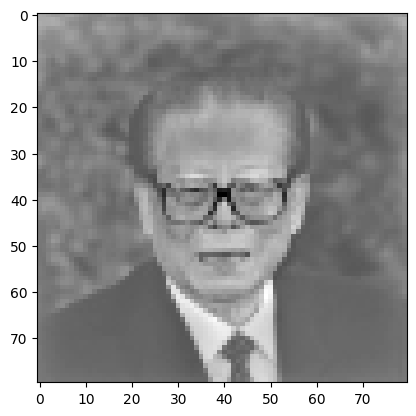

In [43]:
model_filename = './model.pkl'

pickle.dump(clf, open(model_filename, 'wb'))

# load the model from disk

loaded_model = pickle.load(open(model_filename, 'rb'))

# Test the model on a random image

index = np.random.randint(len(filtered_dataset['data']))

test_image = filtered_dataset['data'][index]

plt.imshow(test_image, cmap='gray')

test_image = test_image.reshape(1, -1)

test_image_pca = pca.transform(test_image)

pred = loaded_model.predict(test_image_pca)

print("Predicted label:", pred[0])
print("Actual label:", filtered_dataset['target'][index])

## 7. Test WITH REAL IMAGE

In [46]:
test_image = cv2.imread('./Data/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg')

test_image = resize_image([test_image], target_size=(80, 80))[0]

test_image = gray_scale([test_image])[0]

# Scale the image
test_image = scaler.transform(test_image.reshape(1, -1))

# Reduce the dimensions
test_image = pca.transform(test_image)

# Make a prediction

pred = clf.predict(test_image)[0]

print("Prediction:", pred)

Prediction: Hugo_Chavez
